# Credit Card Notebook_XGBoost

In [13]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier, plot_importance, DMatrix, plot_tree

In [14]:
% cd /Users/MiroWang/Desktop/Github Repo/CreditFraudData

/Users/MiroWang/Desktop/Github Repo/CreditFraudData


In [15]:
train_frame = pd.read_csv("train_frame_creditcard.csv", index_col = 0)

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit
X_xgb = train_frame[train_frame.columns[:-1]].as_matrix()
y_xgb = train_frame['Class'].astype("int")

strsplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=36)
for train_index, test_index in strsplit.split(X_xgb, y_xgb):
    X_train_xgb, X_test_xgb = X_xgb[train_index], X_xgb[test_index]
    y_train_xgb, y_test_xgb = y_xgb[train_index], y_xgb[test_index]
    
print(X_train_xgb.shape, X_test_xgb.shape, y_train_xgb.shape, y_test_xgb.shape)

(205060, 29) (51266, 29) (205060,) (51266,)


## First tune basic tree parameters

xgbclf to tune basic tree parameters

In [52]:
xgbclf = XGBClassifier(scale_pos_weight = 999, silent = True, seed = 6, \
                       objective='binary:logistic', learning_rate =0.1,  max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8)
parameters = {'n_estimators':[220, 240, 350], 'max_depth':[7, 9]}
clf_search = GridSearchCV(xgbclf, parameters, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

In [53]:
import timeit
start = timeit.default_timer()
clf_search.fit(X_train_xgb, y_train_xgb)
stop = timeit.default_timer()
print("Fitting Time: %s seconds" % (stop - start))

Fitting Time: 1494.8844428730008 seconds


In [54]:
y_score = clf_search.predict_proba(X_test_xgb)

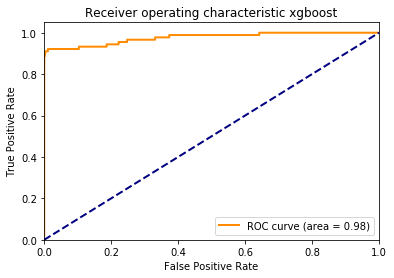

In [55]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, confusion_matrix, precision_score, recall_score

fpr_rf, tpr_rf, threshold = roc_curve(y_test_xgb, y_score[:,1])

def plot_roc(fpr, tpr):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic xgboost')
    plt.legend(loc="lower right")
    plt.show()
    
plot_roc(fpr_rf, tpr_rf)

In [56]:
xgb_cm = confusion_matrix(y_test_xgb, clf_search.best_estimator_.predict(X_test_xgb))
print ("cost of xgboost classifier %s" % (xgb_cm[0][1]*1 + xgb_cm[1][0]*1000))

cost of xgboost classifier 13008


/Users/MiroWang/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [57]:
xgb_cm

array([[51169,     8],
       [   13,    76]])

In [51]:
clf_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=240,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=999, seed=6,
       silent=True, subsample=0.8)

## Second tune the min_child_weight and gamma

min_child_weight"minimum number of instances needed to be in each node"[xgboost documentation](http://xgboost.readthedocs.io/en/latest/parameter.html). As min_child_weight became larger, the model becomes more conservative.

In [69]:
xgbclf2 = XGBClassifier(scale_pos_weight = 999, silent = True, seed = 6, \
                       objective='binary:logistic', learning_rate =0.1,  max_depth=7,
 n_estimators = 240, subsample=0.8, colsample_bytree=0.8)
parameters = {'min_child_weight':[3, 5], 'gamma':[0.3, 0.5]}
clf_search2 = GridSearchCV(xgbclf2, parameters, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

In [70]:
import timeit
start = timeit.default_timer()
clf_search2.fit(X_train_xgb, y_train_xgb)
stop = timeit.default_timer()
print("Fitting Time: %s seconds" % (stop - start))

Fitting Time: 883.6016382309972 seconds


In [71]:
xgb_cm2 = confusion_matrix(y_test_xgb, clf_search2.best_estimator_.predict(X_test_xgb))
print ("cost of xgboost classifier %s" % (xgb_cm2[0][1]*1 + xgb_cm2[1][0]*1000))

cost of xgboost classifier 11011


/Users/MiroWang/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [72]:
xgb_cm2

array([[51166,    11],
       [   11,    78]])

In [73]:
clf_search2.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.3, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=5, missing=None,
       n_estimators=240, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=999, seed=6, silent=True,
       subsample=0.8)

## Tune col_sample and consider using early stop to avoid overfit